In [16]:
import pandas as pd
import os
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display, Audio

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
GENDER = 'female'
AGES = ["thirties", "forties"]
DATA_DIR = '/media/jq/ugreen/Data/speech/'
NUM_SAMPLES = 15000
NUM_VALIDATION_SAMPLES = 500
SAMPLE_RATE = 20500

In [3]:
c1 = pd.read_csv(
    os.path.join(DATA_DIR, 'cv-corpus-10.0-2022-07-04/lg/train.tsv'),
    sep=r'\t', engine="python")

c2 = pd.read_csv(
    os.path.join(DATA_DIR, 'cv-corpus-10.0-2022-07-04/lg/dev.tsv'),
    sep=r'\t', engine="python")

c3 = pd.read_csv(
    os.path.join(DATA_DIR, 'cv-corpus-10.0-2022-07-04/lg/test.tsv'),
    sep=r'\t', engine="python")

clips = pd.concat([c1, c2, c3], ignore_index=True)

In [4]:
clips['score'] = clips['up_votes'] - clips['down_votes']
clips = clips.sort_values(by='score', ascending=False)
clips = clips[clips['sentence'].str.contains('…') == False]  # ellipses may indicate text is incomplete?
clips = clips[clips.gender == GENDER].head(NUM_SAMPLES)
clips = clips[clips.age.isin(AGES)].head(NUM_SAMPLES)
clips = clips.sample(frac=1, random_state=0)  # shuffle so that we distribute the different speakers evenly

In [5]:
len(clips)

6576

In [ ]:
for i in range(5):
    path = clips.path.iloc[i]
    display(Audio(os.path.join(DATA_DIR, 'cv-corpus-10.0-2022-07-04/lg/clips', path)))

Decode from .mp3 and save to a .wav with 32k bitrate (needed for voice activity detection, below).

In [ ]:
wav_32k_dir = os.path.join(
    DATA_DIR,
    f'tts/lg/{GENDER}/wav_32k/'
)
!mkdir -p {wav_32k_dir}

def convert_clip(path):
    source_mp3_path = os.path.join(
        DATA_DIR,
        'cv-corpus-10.0-2022-07-04/lg/clips',
        path,
    )

    output_wav_path = os.path.join(
        wav_32k_dir,
        path.replace('.mp3', '.wav')
    )

    !ffmpeg -i {source_mp3_path} -ar 32000 -y {output_wav_path} 2> /dev/null

with tqdm(total=len(clips)) as pbar:
    with ThreadPoolExecutor(max_workers=6) as ex:
        futures = [ex.submit(convert_clip, path) for path in clips.path]
        for future in as_completed(futures):
            pbar.update(1)

In [17]:
def mp3_path_to_wav_path(path):
    return path.replace('.mp3', '.wav')

clips['wav_path'] = clips.path.apply(mp3_path_to_wav_path)

Filter out silences from the beginning and end of the recording. This is important for TTS training in order to be able to align the text and audio.

The code in this cell is mostly reused from [this example](https://github.com/wiseman/py-webrtcvad/blob/master/example.py) in py-webrtcvad, for voice activity detection. It's not enough to delete silences, as there are other non-voice background sounds present in the recordings.

In [ ]:
import collections
import contextlib
import sys
import wave
import webrtcvad
import librosa

def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        sample_rate = 32000  # We will pretend it's sampled at 16k
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    """Writes a .wav file.
    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.
    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.
    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.
    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.
    Arguments:
    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).
    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.5 * ring_buffer.maxlen:
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []

    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])

filtered_tmp_dir = os.path.join(
    DATA_DIR, f'tts/lg/{GENDER}/wav_filtered/'
)
final_wav_dir = os.path.join(
    DATA_DIR, f'tts/lg/{GENDER}/wavs/'
)

!mkdir -p {filtered_tmp_dir}
!mkdir -p {final_wav_dir}

bad_files = []

for wav_path in tqdm(clips.wav_path):
    filename = os.path.basename(wav_path)
    if not os.path.exists(os.path.join(final_wav_dir, filename)):
        audio, sample_rate = read_wave(
            os.path.join(wav_32k_dir, filename))
        vad = webrtcvad.Vad(3)
        frames = frame_generator(30, audio, sample_rate)
        frames = list(frames)
        segments = vad_collector(sample_rate, 30, 300, vad, frames)
        speech = b''.join(list(segments))
        # Likely to be a problem if less than 1s of speech
        if len(speech) < sample_rate * 2:
            bad_files.append(wav_path)        
        else:
            write_wave(
                os.path.join(filtered_tmp_dir, filename),
                speech, sample_rate)
            # Resample to SAMPLE_RATE
            wav, _ = librosa.load(
                os.path.join(filtered_tmp_dir, filename),
                sr=SAMPLE_RATE)
            soundfile.write(
                os.path.join(final_wav_dir, filename),
                wav[:-20000], SAMPLE_RATE)  # Trim a little extra from the end

Some audio files may not have had any speech, so filter them out.

In [76]:
clips = clips[~clips.wav_path.isin(bad_files)]

print(f'Remove {len(bad_files)} files without speech, new total: {len(clips)}.')

Remove 6 files without speech, new total: 6570.


Have a look and a listen to make sure the cropping is correct, without silences and also without cutting off the speech.

Abalaguzi, ebintu byabwe ebisinga obungi babikolera mu ssabo.


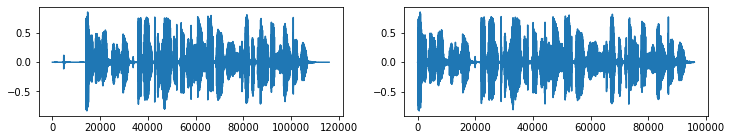

Baakozesa engabo n'obusaale okutta ekisolo.


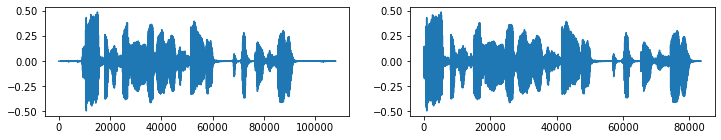

Abasiraamu abasinga basaalira Kibuli .


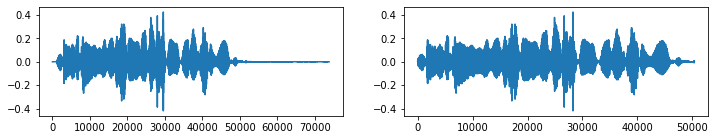

Omugugu ogwekinyi gwe basiba ne gunywera nga munene nnyo, ne bagulinnyako, ne bagukulungula.


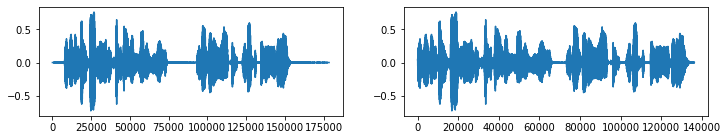

Abantu basaanye okusigala ku bwerinde, kisobole okubataasa ku kirwadde kino ekya ssennyiga Kolona.


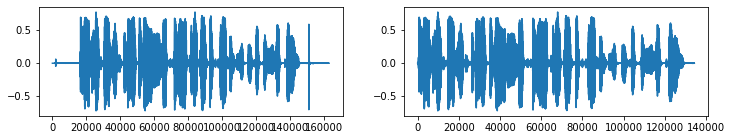

In [56]:
for i in range(5, 10):
    print(clips.sentence.iloc[i])
    filename = clips.wav_path.iloc[i]
    wav1, rate1 = librosa.load(os.path.join(wav_32k_dir, filename))
    wav2, rate2 = librosa.load(os.path.join(final_wav_dir, filename))
    plt.subplot(121)
    plt.plot(wav1)
    plt.subplot(122)
    plt.plot(wav2)
    plt.gcf().set_size_inches(12, 2)
    plt.show()
    display(Audio(data=wav1, rate=rate1))
    display(Audio(data=wav2, rate=rate2))

Next, tidy up the text, including replacement of non-ascii characters.

In [78]:
replacements = {
    'ŋ':'ng',
    'ղ':'ng',
    '‘':'\'',
    '’':'\'',
    '“':'\'',
    '”':'\'',
    '"':'\'',
    '…':' ',
    '`':'',
}

def replace_characters(s, replacements):
    for c in replacements.keys():
        s = s.replace(c, replacements[c])
    return s

def generate_LJSpeech_line(row):
    cleaned = replace_characters(row["sentence"], replacements)
    file_id = os.path.basename(row["path"][:-4])
    text = f'{file_id}|{cleaned}|{cleaned}'
    return text

def write_LJSpeech_format(df):    
    lines = list(df.apply(generate_LJSpeech_line, axis=1))                 
    with open(f'{DATA_DIR}/tts/lg/{GENDER}/metadata.csv', 'w') as f:
        f.write('\n'.join(lines))
        
write_LJSpeech_format(clips)

In [80]:
metadata_path = f'{DATA_DIR}/tts/lg/{GENDER}/metadata.csv'
!head {metadata_path}

common_voice_lg_28117097|Bwe baava awo baggukira mu bbaala.|Bwe baava awo baggukira mu bbaala.
common_voice_lg_28119635|Kisinga akatungulu era tekibula mu kyogero kuba kiwa emikisa.|Kisinga akatungulu era tekibula mu kyogero kuba kiwa emikisa.
common_voice_lg_28162710|Laga ekigezeso ky'ekiteeberezo ekyafaanana okuba ekituufu.|Laga ekigezeso ky'ekiteeberezo ekyafaanana okuba ekituufu.
common_voice_lg_27956575|Emmere y'omu ttaka tekozebwa wabula ewuutirizibwa.|Emmere y'omu ttaka tekozebwa wabula ewuutirizibwa.
common_voice_lg_24950163|Weetaba mu bikolwa ki?|Weetaba mu bikolwa ki?
common_voice_lg_28233664|Abalaguzi, ebintu byabwe ebisinga obungi babikolera mu ssabo.|Abalaguzi, ebintu byabwe ebisinga obungi babikolera mu ssabo.
common_voice_lg_28119749|Baakozesa engabo n'obusaale okutta ekisolo.|Baakozesa engabo n'obusaale okutta ekisolo.
common_voice_lg_24979887|Abasiraamu abasinga basaalira Kibuli .|Abasiraamu abasinga basaalira Kibuli .
common_voice_lg_28197865|Omugugu ogwekinyi gwe bas

In [81]:
%cd {DATA_DIR}/tts/lg/{GENDER}
!tar -czf tts-luganda-{GENDER}.tar.gz metadata.csv wavs

/media/jq/ugreen/Data/speech/tts/lg/female


Optionally get the duration of each file and add it to the dataframe (a bit slow).

In [110]:
add_duration_to_data_frame = False

def get_duration(wav_filename, location):
    wav, rate = librosa.load(
        os.path.join(location, wav_filename))
    return len(wav) / rate

if add_duration_to_data_frame:
    clips['duration'] = clips.wav_path.apply(
        lambda x: get_duration(x, final_wav_dir))

Print some overview stats about duration (fast).

In [87]:
durations = !soxi -D {final_wav_dir}/*
durations = np.array(durations).astype(np.float32)

In [102]:
total_duration = np.sum(durations) / 3600.
min_duration = np.min(durations)
max_duration = np.max(durations)
mean_duration = np.mean(durations)

print(f'{len(clips)} files totalling {total_duration:.1f} hours,')
print(f'min: {min_duration:.1f}s, '
      f'max: {max_duration:.1f}s, '
      f'mean: {mean_duration:.1f}s.')

6570 files totalling 6.6 hours,
min: 0.2s, max: 9.2s, mean: 3.6s.


Clean up temporary directories

In [121]:
!rm -f {filtered_tmp_dir}/*.wav
!rm -f {resampled_tmp_dir}/*.wav
!rm -f {wav_32k_dir}/*.wav
!rmdir {filtered_tmp_dir} {resampled_tmp_dir} {wav_32k_dir}